In [ ]:
import xarray as xr
import scipy.io as io
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
import random

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import cmocean
from pyproj import Geod
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable



path = '/Users/own/data/path'

# Define file paths in a dictionary
filepaths = {
    # Subsidence

    #S1
    'csk_201819_orgsub': f'{path}/subsidence_data/spatial_fil_data/Chersky_S1_spatial_filt/S1_20181004_20190929_vert_filt_1500px_gcs_masked.nc',
    'csk_201920_orgsub': f'{path}/subsidence_data/spatial_fil_data/Chersky_S1_spatial_filt/S1_20190929_20201005_vert_filt_1500px_gcs_masked.nc',



    




}



# ==============================
#   1️⃣  DATA HANDLING FUNCTIONS
# ==============================



def prepare_subsidence_data(loc, year, vartype, min_value=-0.5, max_value=0.5, near_zero_threshold=1e-5):
    ''' Preparing subsidence data while ensuring matching grid sizes. '''
    filepath = filepaths[f"{loc}_{year}_{vartype}"] 
    ds = Dataset(filepath, mode='r')

    lon_var_name = 'lon' if 'lon' in ds.variables else 'longitude'
    lat_var_name = 'lat' if 'lat' in ds.variables else 'latitude'
    
    lons = ds.variables[lon_var_name][:]
    lats = ds.variables[lat_var_name][:]
    subsidence = ds.variables['Band1'][:]

    # Creating meshgrid for lons and lats
    lon_mesh, lat_mesh = np.meshgrid(lons, lats)
    
    # Flatten the arrays
    lons_flat = lon_mesh.ravel()
    lats_flat = lat_mesh.ravel()
    subsidence_flat = subsidence.ravel()
    
    # complete removal of unwanted data
    zip_data = np.column_stack((lons_flat, lats_flat, subsidence_flat))
    # Ensure grid dimensions match before flattening
    # if subsidence.shape != (len(lons[:,0]), len(lons[0,:])):
    #     raise ValueError(f"Grid size mismatch! Subsidence: {subsidence.shape}, Lons: {len(lons[:,0])}, Lats: {len(lons[0,:])}")

    
    

    # Check if all arrays have the same length
    if len(lons_flat) != len(subsidence_flat):
        raise ValueError(f"Mismatch: lons_flat ({len(lons_flat)}), subsidence_flat ({len(subsidence_flat)})")

    mask = (
        (subsidence_flat >= min_value) &
        (subsidence_flat <= max_value) &
        ~((subsidence_flat > -near_zero_threshold) & (subsidence_flat < near_zero_threshold))
    )

    # # Remove the masked data
    zip_masked = zip_data[mask]

    ds.close()
    return subsidence, lons, lats, zip_masked




def prepare_ERA_data(loc, year, vartype, varname):
    '''Prepare non-subsidence data'''

    # Load the dataset
    filepath = filepaths[f"{loc}_{year}_{vartype}"]
    ds = Dataset(filepath, mode='r')

    # Determine the correct variable names for longitude and latitude
    lon_var_name = 'lon' if 'lon' in ds.variables else 'longitude'
    lat_var_name = 'lat' if 'lat' in ds.variables else 'latitude'

    # Load longitude and latitude arrays
    lons = ds.variables[lon_var_name][:]
    lats = ds.variables[lat_var_name][:]

    # Extract the variable data
    var_data = ds.variables[varname][...]  # Load entire variable safely

    # **Handle different number of dimensions**
    if var_data.ndim == 3:  # Standard (time, lat, lon)
        var_data = var_data[0, :, :]  # Take the first time step
    elif var_data.ndim == 2:  # Already (lat, lon), no need to slice
        pass
    elif var_data.ndim == 1:  # 1D variable, may need reshaping
        print(f"Warning: Variable {varname} is 1D. Manual reshaping may be needed.")

    ds.close()

    return var_data, lons, lats



# Define variables to load
filenames = ['elv']
varnames = ['Band1']
#elv-Band1 slp-slope  

def load_ERA_data(region, year, filename, varname):
    """
    Load ERA5 data for multiple variables efficiently.

    Parameters:
        region (str): The region identifier (e.g., 'csk').
        year (str): The year range as a string (e.g., '201819').
        category (str): The category of data (e.g., 'temperature').
        variables (list): List of variable names to load (e.g., ['skt', 'stl1']).

    Returns:
        dict: A dictionary with variable names as keys and data arrays as values.
    """
    data_dict = {}
    
    for filename, varname in zip(filenames, varnames):
        data, lons, lats = prepare_ERA_data(region, year, filename, varname)
        data_dict[varname] = data  # Store the loaded data with varname as the key

    return data_dict, lons, lats





# ==============================
#   2️⃣  GRIDDIND AND BINNING
# ==============================

def regroup_and_generate_histograms(grid, data, bins=50, min_val=-0.02, max_val=0.02, threshold=6000, plot=True):
    '''Regroup data into subsets based on grid and generate binned histograms.'''
    histograms = []
    grid_info = []  # Keep track of grid location and valid data points
    
    for idx, cell in enumerate(grid):
        lon_start, lon_end, lat_start, lat_end = cell
        
        # Mask data for the current grid cell
        mask = (data[:, 0] >= lon_start) & (data[:, 0] < lon_end) & \
               (data[:, 1] >= lat_start) & (data[:, 1] < lat_end)
        subset = data[mask][:, 2]
        
        # Debugging: Log grid cell details
        print(f"Grid {idx}: Lon {lon_start}-{lon_end}, Lat {lat_start}-{lat_end}, Points: {len(subset)}")
        
        if len(subset) > 0:
            # Compute histogram for the subset
            hist, _ = np.histogram(subset, bins=bins, range=(min_val, max_val), density=True)
            
            # Debugging: Log histogram details
            print(f"Histogram for Grid {idx}: {hist}")
            
            # Threshold check
            if len(subset) >= threshold:
                histograms.append(hist)  # Include histogram only if it has enough data
            else:
                histograms.append(np.full(bins, np.nan))  # Mark histograms with insufficient data as NaN
        else:
            histograms.append(np.full(bins, np.nan))  # Mark empty grids as NaN
        
        # Append grid info
        grid_info.append({
            "lon_start": lon_start,
            "lon_end": lon_end,
            "lat_start": lat_start,
            "lat_end": lat_end,
            "num_points": len(subset)
        })

        # Plot the histogram if required
        if plot and len(subset) > 0:
            plt.figure(figsize=(8, 6))
            plt.hist(subset, bins=bins, range=(min_val, max_val), edgecolor='black')
            plt.title(f'Grid Cell Histogram (Lon: {lon_start:.2f}-{lon_end:.2f}, Lat: {lat_start:.2f}-{lat_end:.2f})\nPoints: {len(subset)}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

    # Debugging: Log final histogram shape and contents
    print(f"Final histogram array shape: {np.array(histograms).shape}")
    print(f"Histogram array contents: {np.array(histograms)}")
    
    return np.array(histograms), grid_info


def create_km_grid(lon_mesh, lat_mesh, resolution_km=10, output_file='grid_description.nc'):
    '''
    Create a new grid with a specified resolution in kilometers.

    Parameters:
        lon_mesh (ndarray): Original longitude mesh.
        lat_mesh (ndarray): Original latitude mesh.
        resolution_km (float): Desired grid resolution in kilometers.

    Returns:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
    '''
    geod = Geod(ellps="WGS84")

    # Find the bounds of the original data
    lon_min, lon_max = lon_mesh.min(), lon_mesh.max()
    lat_min, lat_max = lat_mesh.min(), lat_mesh.max()

    # Calculate the step size in degrees for the specified resolution in km
    def calculate_step(start, end, resolution, is_latitude):
        steps = [start]
        current = start

        while current < end:
            if is_latitude:
                # Latitude distances are approximately constant
                next_point = geod.fwd(lon_mesh.mean(), current, 0, resolution * 1000)[1]
            else:
                # Longitude distances vary with latitude
                next_point = geod.fwd(current, lat_mesh.mean(), 90, resolution * 1000)[0]

            steps.append(next_point)
            current = next_point

        return np.array(steps)

    lat_steps = calculate_step(lat_min, lat_max, resolution_km, is_latitude=True)
    lon_steps = calculate_step(lon_min, lon_max, resolution_km, is_latitude=False)

    # Create the grid as a list of bounding boxes
    grid = []
    for i in range(len(lat_steps) - 1):
        for j in range(len(lon_steps) - 1):
            grid.append((lon_steps[j], lon_steps[j + 1], lat_steps[i], lat_steps[i + 1]))


    return grid


def bin_valid_data(grid, data, bins=50, min_val=None, max_val=None, threshold=6000):
    '''
    Bin valid data points in each grid into the specified number of bins.

    Parameters:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
        data (ndarray): Data array containing longitude, latitude, and values.
        bins (int): Number of bins for the histogram.
        min_val (float): Minimum value for the histogram range (optional).
        max_val (float): Maximum value for the histogram range (optional).

    Returns:
        histograms (ndarray): 2D array of normalized histograms for each grid.
        grid_info (list): List of information about each grid cell.
    '''
    # Dynamically set min_val and max_val if not provided
    if min_val is None or max_val is None:
        min_val = data[:, 2].min()
        max_val = data[:, 2].max()
        print(f"Using dynamic range: min_val={min_val:.4f}, max_val={max_val:.4f}")

    histograms = []
    data_density = []  # Store the number of valid points per grid
    valid_indices = []  # Store the indices of valid points in each grid
    
    for i, cell in enumerate(grid):
        lon_start, lon_end, lat_start, lat_end = cell
        
        # Mask data points belonging to the current grid cell
        mask = (
            (data[:, 0] >= lon_start) & (data[:, 0] < lon_end) &
            (data[:, 1] >= lat_start) & (data[:, 1] < lat_end)
        )
        subset = data[mask][:, 2]
        
        if len(subset) > threshold:
            # Print min and max values for the grid's subset
            print(f"Grid ({lon_start:.2f}, {lon_end:.2f}, {lat_start:.2f}, {lat_end:.2f}): "
                  f"min={subset.min():.4f}, max={subset.max():.4f}, points={len(subset)}")

            # Compute histogram
            hist, _ = np.histogram(subset, bins=bins, range=(min_val, max_val), density=True)
            histograms.append(hist)
            valid_indices.append(i)
        else:
            # Append NaN array if no valid points in the grid cell
            histograms.append(np.full(bins, np.nan))
        
        # Store grid cell information
        data_density.append(len(subset))

    return np.array(histograms), data_density, valid_indices



def create_cdo_grid_description(grid, output_file='grid_description.txt'):
    """
    Create a CDO-compatible grid description file based on input grid cells for a curvilinear grid.

    Parameters:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
        output_file (str): File name for the output grid description text file.

    Returns:
        None
    """

    # Extract unique longitudes and latitudes from the grid
    lon_coords = sorted(set(cell[0] for cell in grid))
    lat_coords = sorted(set(cell[2] for cell in grid))

    # Calculate grid dimensions
    xsize = len(lon_coords)
    ysize = len(lat_coords)
    gridsize = xsize * ysize

    # Prepare grid description text for a curvilinear grid
    description = [f"gridtype = curvilinear", f"xsize = {xsize}", f"ysize = {ysize}", f"gridsize = {gridsize}"]

    # Convert coordinates into 2D arrays (longitude and latitude grid points)
    lon_array, lat_array = np.meshgrid(lon_coords, lat_coords)

    # Write to file
    with open(output_file, 'w') as f:
        f.write("\n".join(description))
        f.write("\n")

        # Write longitude (xvals) and latitude (yvals) arrays
        f.write("xvals = ")
        np.savetxt(f, lon_array.flatten(), fmt="%.6f", newline=" ")
        f.write("\n")

        f.write("yvals = ")
        np.savetxt(f, lat_array.flatten(), fmt="%.6f", newline=" ")
        f.write("\n")

    print(f"Curvilinear grid description file written to {output_file}")


def combine_variables_by_grid(*variables):
    """
    Combine multiple variables into a single 3D matrix based on grid indexing.

    Parameters:
        *variables (ndarrays): A list of 2D arrays (e.g., 27x20) representing different variables
                               aligned to the same grid size.

    Returns:
        ndarray: A 3D array with shape (grid_rows, grid_cols, num_variables),
                 preserving spatial arrangement.
    """
    # Ensure all input variables have the same shape
    shapes = [var.shape for var in variables]
    if len(set(shapes)) != 1:
        raise ValueError("All input variables must have the same shape.")

    # Stack the variables along a new axis (depth dimension)
    combined_matrix = np.stack(variables, axis=-1)  # Shape: (rows, cols, num_variables)

    return combined_matrix  # Preserves 2D grid structure



# ==============================
#   3️⃣  CLUSTERING FUNCTION
# ==============================

class EPMEANS:
    '''# EP-MEANS Clustering
        Custom clustering using EMD'''
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, histograms):
        # Initialize centroids using KMeans++
        kmeans_init = KMeans(n_clusters=self.n_clusters, init="k-means++", random_state=42).fit(histograms)
        self.centroids = kmeans_init.cluster_centers_

        for iteration in range(self.max_iter):
            # Assign each histogram to the nearest centroid based on EMD
            assignments = np.array([
                np.argmin([wasserstein_distance(hist, centroid) for centroid in self.centroids])
                for hist in histograms
            ])

            # Update centroids
            new_centroids = []
            for i in range(self.n_clusters):
                cluster_data = histograms[assignments == i]
                if len(cluster_data) > 0:
                    new_centroids.append(np.mean(cluster_data, axis=0))
                else:
                    new_centroids.append(self.centroids[i])  # Keep old centroid if cluster is empty
            new_centroids = np.array(new_centroids)

            # Check for convergence
            centroid_shift = np.linalg.norm(self.centroids - new_centroids, axis=1).max()
            self.centroids = new_centroids
            if centroid_shift < self.tol:
                break

        self.assignments = assignments

    def predict(self, histograms):
        return np.array([
            np.argmin([wasserstein_distance(hist, centroid) for centroid in self.centroids])
            for hist in histograms
        ])
    



# ==============================
#   4️⃣  VISUALIZATION FUNCTIONS
# ==============================



def plot_with_colorbar(data, lon, lat, title="Subsidence Data", cmap='curl', levels='sub', label='Subsidence (m)', vmin=None, vmax=None):
    '''Plot data with a color bar, correctly labeled longitude/latitude axes, and adjusted aspect ratio'''

    # Ensure lon and lat are 2D arrays
    if len(lon.shape) == 1 and len(lat.shape) == 1:
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    else:
        lon_mesh, lat_mesh = lon, lat

    # Use Geod to calculate the distance in kilometers
    geod = Geod(ellps="WGS84")
    lat_km_span = geod.line_length([lon_mesh.min(), lon_mesh.min()],
                                   [lat_mesh.min(), lat_mesh.max()]) / 1000
    lon_km_span = geod.line_length([lon_mesh.min(), lon_mesh.max()],
                                   [lat_mesh.mean(), lat_mesh.mean()]) / 1000

    # Calculate grid size in km
    grid_lat_km = geod.line_length([lon_mesh[0, 0], lon_mesh[0, 0]], [lat_mesh[0, 0], lat_mesh[1, 0]]) / 1000
    grid_lon_km = geod.line_length([lon_mesh[0, 0], lon_mesh[0, 1]], [lat_mesh[0, 0], lat_mesh[0, 0]]) / 1000

    # Print the grid size and the longitude/latitude spans
    print(f"Latitude span: {lat_km_span:.2f} km")
    print(f"Longitude span: {lon_km_span:.2f} km")
    print(f"Grid size: {grid_lat_km:.2f} km x {grid_lon_km:.2f} km")

    # Calculate the aspect ratio based on the span in kilometers
    aspect_ratio = lat_km_span / lon_km_span

    # Set the color map
    if isinstance(cmap, str):  
        if cmap in cmocean.cm.__dict__:
            cmap = cmocean.cm.__dict__[cmap]
        elif cmap in plt.colormaps():
            cmap = plt.get_cmap(cmap)
        else:
            raise ValueError(f"Invalid colormap: '{cmap}' is not in cmocean or matplotlib.")
  

    # Define discrete levels
    if levels == 'sub':
        if vmin is None and vmax is None:
            levels = np.linspace(-0.1, 0.1, 11)
        else:
            levels = np.linspace(vmin, vmax, 11)
        label = 'Subsidence (m)'
    elif levels == 'None':
        if vmin is None and vmax is None:
            vmin = data.min()
            vmax = data.max()
        levels = np.linspace(vmin, vmax, 11)

    # Create a normalization that splits the color map into discrete intervals
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Create the plot with proportional aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10 * aspect_ratio))

    # Use pcolormesh for plotting
    mesh = ax.pcolormesh(lon_mesh, lat_mesh, data, shading='auto', cmap=cmap, norm=norm)

    # Add a color bar
    cbar = fig.colorbar(mesh, ax=ax, label=label, ticks=levels)

   

    # Shift the grid lines by half a grid size
    lon_interval = (lon_mesh[0, 1] - lon_mesh[0, 0])
    lat_interval = (lat_mesh[1, 0] - lat_mesh[0, 0])

    # Set axis limits and labels
    ylim_min = lat_mesh.min() - lat_interval / 2
    ylim_max = lat_mesh.max() + lat_interval / 2
    xlim_min = lon_mesh.min() - lon_interval / 2
    xlim_max = lon_mesh.max() + lon_interval / 2
    ax.set_xlim([xlim_min, xlim_max])
    ax.set_ylim([ylim_min, ylim_max])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    print(f"Longitude range: {xlim_min:.2f} to {xlim_max:.2f}")
    print(f"Latitude range: {ylim_min:.2f} to {ylim_max:.2f}")
    print(f"grid number: {len(lon_mesh[0])} x {len(lat_mesh)}")
    

    # Add shifted grid lines
    for i in range(lat_mesh.shape[0] + 1):
        shifted_lat = lat_mesh[0, 0] + i * lat_interval - lat_interval / 2
        ax.axhline(shifted_lat, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    for j in range(lon_mesh.shape[1] + 1):
        shifted_lon = lon_mesh[0, 0] + j * lon_interval - lon_interval / 2
        ax.axvline(shifted_lon, color='black', linestyle='--', linewidth=0.5, alpha=0.7)

    # Set the aspect ratio of the actual data plot
    ax.set_box_aspect(aspect_ratio)  # aspect_ratio is width/height

    plt.show()




def visualize_clustering_with_exclusion_and_histograms(grid, assignments, valid_histograms, valid_grids_mask, data_counts, n_clusters, title="Clustering Result Visualization"):
    '''
    Visualize the clustering result with grids that have less than 3000 data points marked as grey,
    and include histogram plots for each cluster.

    Parameters:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
        assignments (ndarray): Cluster assignments for valid grids.
        valid_histograms (ndarray): Normalized histograms for valid grids.
        valid_grids_mask (ndarray): Boolean mask for grids with valid histograms.
        data_counts (list): Number of valid data points in each grid.
        n_clusters (int): Number of clusters.
        title (str): Title of the plot.
    '''
    # Define custom colors for clusters and excluded grids
    custom_colors = [
        "#416E6F",  # Green
        "#EC9F72",  # Orange
        "#8D91C0",  # Purple
        "#DED88B",  # Yellow
        "#A26C66",  # Red-Brown
    ]
    custom_colors = custom_colors[:n_clusters]  # Adjust to the number of clusters
    cmap = {i: custom_colors[i] for i in range(n_clusters)}

    # White for grids with NaN histograms and grey for excluded grids
    cmap[-1] = "white"  # No Data (NaN histograms)
    cmap[-2] = "grey"   # Excluded grids (<3000 data points)

    geod = Geod(ellps="WGS84")

    # Calculate the geographic extent in kilometers
    lat_min = min([cell[2] for cell in grid])
    lat_max = max([cell[3] for cell in grid])
    lon_min = min([cell[0] for cell in grid])
    lon_max = max([cell[1] for cell in grid])

    width_km = geod.line_length([lon_min, lon_max], [lat_min, lat_min]) / 1000
    height_km = geod.line_length([lon_min, lon_min], [lat_min, lat_max]) / 1000

    # Create a plot with proportional aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10 * height_km / width_km))

    for i, cell in enumerate(grid):
        lon_start, lon_end, lat_start, lat_end = cell
        if not valid_grids_mask[i]:  # Grids with NaN histograms or excluded grids
            cluster = -1 if data_counts[i] == 0 else -2
        else:
            valid_index = np.sum(valid_grids_mask[:i])  # Correctly map to valid assignments
            cluster = assignments[valid_index]

        # Draw the grid cell with the corresponding color
        rect = plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                             facecolor=cmap[cluster], edgecolor='black', lw=0.5)
        ax.add_patch(rect)

    # Set axis limits and labels
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    # Create a legend for the clusters
    legend_patches = [
        plt.Rectangle((0, 0), 1, 1, facecolor=cmap[i], edgecolor='black') for i in range(n_clusters)
    ]
    legend_labels = [f"Cluster {i}" for i in range(n_clusters)]
    legend_patches.append(plt.Rectangle((0, 0), 1, 1, facecolor="grey", edgecolor='black'))
    legend_labels.append("Excluded Grids (<3000 points)")
    legend_patches.append(plt.Rectangle((0, 0), 1, 1, facecolor="white", edgecolor='black'))
    legend_labels.append("No Data")

    ax.legend(legend_patches, legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.show()

    # Visualize the histograms for each cluster
    for cluster_id in range(n_clusters):
        # Get indices of histograms belonging to the current cluster
        cluster_indices = np.where(assignments == cluster_id)[0]
        cluster_histograms = valid_histograms[cluster_indices]  # Select corresponding histograms

        plt.figure(figsize=(8, 6))
        for hist in cluster_histograms:
            plt.plot(hist, alpha=0.5)
        plt.title(f'Cluster {cluster_id} Histograms')
        plt.xlabel('Bins')
        plt.ylabel('Normalized Frequency')
        plt.grid(True)
        plt.show()




def visualize_data_density(grid, data_counts, title="Valid Data Points per Grid", cmap=cmocean.cm.dense,vmax=140000,lvl=11):
    """
    Visualizes the number of valid data points per 10×10 km grid cell,
    ensuring correct geographic distance representation.
    Uses the same grid-based plotting scheme as clustering and subsidence plots.
    """

    geod = Geod(ellps="WGS84")

    # Calculate the geographic extent in kilometers
    lat_min = min([cell[2] for cell in grid])
    lat_max = max([cell[3] for cell in grid])
    lon_min = min([cell[0] for cell in grid])
    lon_max = max([cell[1] for cell in grid])

    width_km = geod.line_length([lon_min, lon_max], [lat_min, lat_min]) / 1000
    height_km = geod.line_length([lon_min, lon_min], [lat_min, lat_max]) / 1000
    print(f"Width: {width_km:.2f} km, Height: {height_km:.2f} km")
    aspect_ratio = 1.0

    # Normalize color scale based on max value
    #norm = plt.Normalize(vmin=0, vmax=140000)#np.nanmax(data_counts)
    #cmap=cmocean.cm.__dict__.get(cmap, cmocean.cm.matter)
    levels = np.linspace(0, vmax, lvl)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Create the plot with proportional aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10 * height_km / width_km), constrained_layout=True)

    for i, cell in enumerate(grid):
        lon_start, lon_end, lat_start, lat_end = cell
        count = data_counts[i]

        # Define grid cell color based on data count
        if np.isnan(count) or count == 0:
            facecolor = "white"  # Empty grids
            edgecolor = "black"
        else:
            facecolor = cmap(norm(count))#cmocean.cm.__dict__.get(cmap, cmocean.cm.matter)(norm(count))
            edgecolor = "black"

        # Draw the grid cell
        ax.add_patch(plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                                   facecolor=facecolor, edgecolor=edgecolor, lw=0.5))

    # Set axis limits and labels
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)


    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("right", size="5%", pad=0.2)


    # Add colorbar based on data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, label="Number of Data Points")

    

    plt.show()




def visualise_grid_results(grid, data_counts,title="Grid Visualization",limit=6000):
    '''
    Visualise grid results based on the number of data points in each grid.

    Parameters:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
        data_counts (list): Number of data points in each grid cell.
    '''
    geod = Geod(ellps="WGS84")

    # Calculate the geographic extent in kilometers
    lat_min = min([cell[2] for cell in grid])
    lat_max = max([cell[3] for cell in grid])
    lon_min = min([cell[0] for cell in grid])
    lon_max = max([cell[1] for cell in grid])

    width_km = geod.line_length([lon_min, lon_max], [lat_min, lat_min]) / 1000
    height_km = geod.line_length([lon_min, lon_min], [lat_min, lat_max]) / 1000

    # Counters for grid statistics
    total_grids = len(grid)
    green_grids = sum(1 for count in data_counts if count >= limit)

    print(f"Total grids: {total_grids}")
    print(f"Green grids (>= {limit} points): {green_grids}")

    # Create the plot with proportional aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10 * height_km / width_km))

    for i, cell in enumerate(grid):
        lon_start, lon_end, lat_start, lat_end = cell
        count = data_counts[i]

        # Define grid cell color based on data count
        if count == 0:
            color = 'white'
        elif count < limit:
            color = 'grey'
        else:
            color = 'green'

        # Draw the grid cell without overlapping edges
        rect = plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                             facecolor=color, edgecolor='black', lw=0.5)
        ax.add_patch(rect)

    # Set axis limits and labels
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    print('longitude:', lon_min, lon_max)
    print('latitude:', lat_min, lat_max)

    plt.show()




def visualise_updated_grid(grid_shape, grid_info, data_counts, title="Updated Grid Visualization with Clustering Results"):
    '''
    Visualise the updated grid with clustering results integrated.

    Parameters:
        grid (list of tuples): List of grid cells as (lon_start, lon_end, lat_start, lat_end).
        data_counts (ndarray): Updated values for each grid cell (should be 2D).
        title (str): Title of the plot.
    '''
    geod = Geod(ellps="WGS84")

    # Calculate the geographic extent in kilometers
    lat_min = min([cell[2] for cell in grid_info])
    lat_max = max([cell[3] for cell in grid_info])
    lon_min = min([cell[0] for cell in grid_info])
    lon_max = max([cell[1] for cell in grid_info])

    width_km = geod.line_length([lon_min, lon_max], [lat_min, lat_min]) / 1000
    height_km = geod.line_length([lon_min, lon_min], [lat_min, lat_max]) / 1000

    # Create the plot with proportional aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10 * height_km / width_km))

    rows, cols = grid_shape.shape[0], grid_shape.shape[1]
    data_counts = np.array((data_counts))
    if data_counts.ndim == 1:
        try:
            data_counts = data_counts.reshape((rows,cols))
        except ValueError:
            print(f"❌ Error: Cannot reshape `data_counts` {data_counts.shape} to `grid_shape` {grid_shape}")
            return

    #assign rows and columns with the same shape as grid 
    


    for i, cell in enumerate(grid_info):
        lon_start, lon_end, lat_start, lat_end = cell

        # **Fix: Properly map 2D data_counts to 1D grid**
        row, col = divmod(i, grid_shape.shape[1])  # Convert linear index to 2D
        value = data_counts[row, col]  # Extract the scalar value

        # **Correct assignment priorities**
        if np.isnan(value) or value == -1:  # No Data
            color = 'white'
        elif value == 0:  # Not Enough Data (<3000 points)
            color = 'white'
        elif value == 111:  # Cluster 1
            color = '#416E6F'
        elif value == 222:  # Cluster 2
            color = '#EC9F72'
        elif value == 333:  # Cluster 3
            color = '#8D91C0'
        elif value == 444:  # Cluster 4
            color = '#DED88B'
        else:  
            color = 'white'  # Default for unexpected values

        # Draw the grid cell
        rect = plt.Rectangle((lon_start, lat_start), lon_end - lon_start, lat_end - lat_start,
                             facecolor=color, edgecolor='black', lw=0.5)
        ax.add_patch(rect)

    # Set axis limits and labels
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    # Add legend
    legend_patches = [
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Invalid Grid'),
        #plt.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='black', label='Not Enough Data (<3000 points)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='#416E6F', edgecolor='black', label='Cluster 1'), #greenblue
        plt.Rectangle((0, 0), 1, 1, facecolor='#EC9F72', edgecolor='black', label='Cluster 2'), #orange
        # plt.Rectangle((0, 0), 1, 1, facecolor='#8D91C0', edgecolor='black', label='Cluster 3'),
        # plt.Rectangle((0, 0), 1, 1, facecolor='#DED88B', edgecolor='black', label='Cluster 4')  
    ]
    ax.legend(
        handles=legend_patches,
        loc='center left',  
        bbox_to_anchor=(1.05, 0.5),  
        frameon=True  
    )

    plt.show()


def modify_cmo_topo():
    """Modify the cmocean 'topo' colormap: replace 0-100m (originally blue) with olive green."""
    topo_cmap = cmocean.cm.topo  # Get the cmocean topo colormap
    new_colors = topo_cmap(np.linspace(0.5, 1, 256))  # Remove lowest blue shades (0.25 removes blues)

    # Manually replace first ~50 colors (low elevation) with olive green
    #new_colors[:50] = mcolors.to_rgba("olive")

    # Create a new colormap
    return mcolors.LinearSegmentedColormap.from_list("custom_cmo_topo", new_colors)

# Create the modified colormap
custom_cmo_topo = modify_cmo_topo()



Curvilinear grid description file written to csk_10km_grid.txt
Total grids: 696
Green grids (>= 6000 points): 485
longitude: 157.1626033 164.2328803471118
latitude: 67.37529056818 69.52695167598218


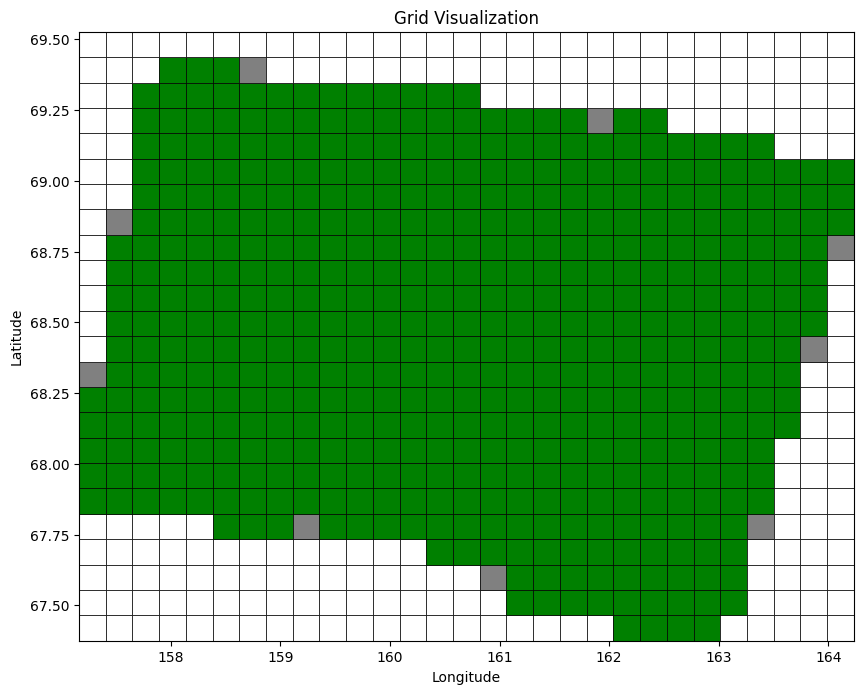

Using dynamic range: min_val=-0.0200, max_val=0.0200
Grid (162.04, 162.28, 67.38, 67.46): min=-0.0200, max=0.0200, points=11373
Grid (162.28, 162.53, 67.38, 67.46): min=-0.0200, max=0.0200, points=78161
Grid (162.53, 162.77, 67.38, 67.46): min=-0.0200, max=0.0200, points=159096
Grid (162.77, 163.01, 67.38, 67.46): min=-0.0200, max=0.0200, points=117532
Grid (161.06, 161.31, 67.46, 67.55): min=-0.0200, max=0.0200, points=8812
Grid (161.31, 161.55, 67.46, 67.55): min=-0.0200, max=0.0200, points=82228
Grid (161.55, 161.79, 67.46, 67.55): min=-0.0200, max=0.0200, points=176206
Grid (161.79, 162.04, 67.46, 67.55): min=-0.0200, max=0.0200, points=257641
Grid (162.04, 162.28, 67.46, 67.55): min=-0.0200, max=0.0200, points=339570
Grid (162.28, 162.53, 67.46, 67.55): min=-0.0200, max=0.0200, points=328548
Grid (162.53, 162.77, 67.46, 67.55): min=-0.0200, max=0.0200, points=228727
Grid (162.77, 163.01, 67.46, 67.55): min=-0.0200, max=0.0200, points=242326
Grid (163.01, 163.26, 67.46, 67.55): min

In [4]:
subsidence_1819, lons, lats, zip_masked_1819 = prepare_subsidence_data('csk', '201819', 'orgsub', min_value=-0.02, max_value=0.02)
csk_grid = create_km_grid(lons, lats, resolution_km=10)
create_cdo_grid_description(csk_grid, output_file='csk_10km_grid.txt')



# Count the number of points in each grid cell
data_counts_1819 = []
for cell in csk_grid:
    lon_start, lon_end, lat_start, lat_end = cell
    mask = (zip_masked_1819[:, 0] >= lon_start) & (zip_masked_1819[:, 0] < lon_end) & (zip_masked_1819[:, 1] >= lat_start) & (zip_masked_1819[:, 1] < lat_end)
    data_counts_1819.append(np.sum(mask))

# Visualise the grid results
visualise_grid_results(csk_grid, data_counts_1819)


hist_csk_1819,_,_ = bin_valid_data(csk_grid, zip_masked_1819, bins=50, min_val=None, max_val=None,threshold=6000)



Valid histograms: 485


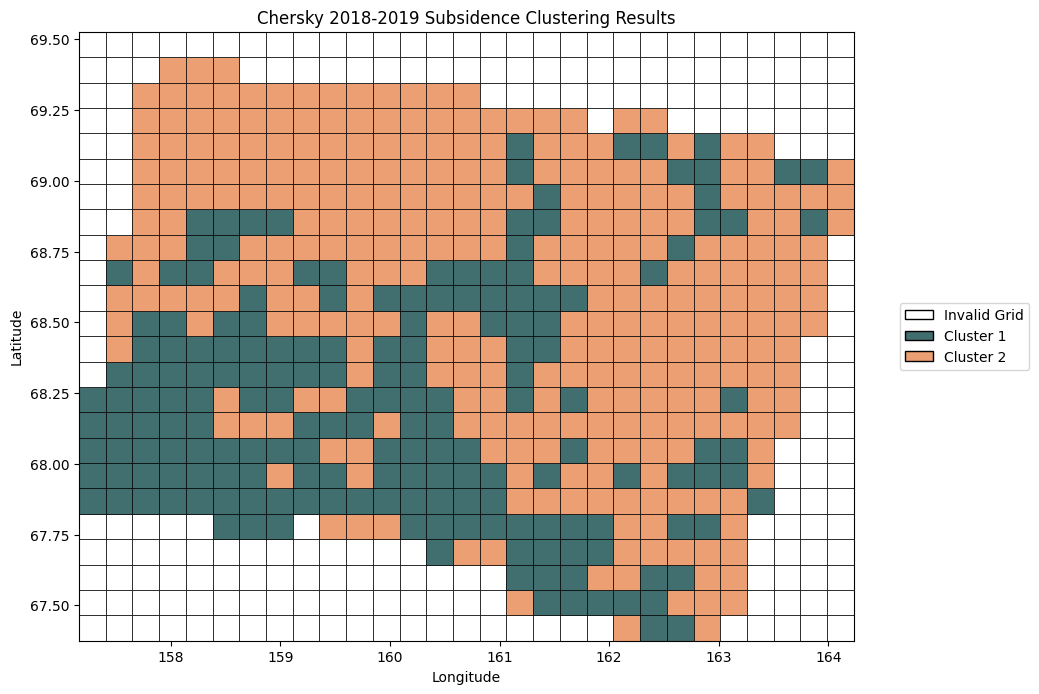

In [5]:

# Ensure valid grids are filtered correctly
data_counts_1819 = np.array(data_counts_1819)
valid_grids_mask = (data_counts_1819 >= 6000)
valid_histograms_1819 = hist_csk_1819[valid_grids_mask]

csk_grids_mask = valid_grids_mask.reshape(24, 29)  

# Save the mask for later use
np.save('csk_grids_mask.npy', csk_grids_mask)

if valid_histograms_1819.size == 0:
    print("No valid histograms found. Ensure input data has sufficient values.")
else:
    print(f"Valid histograms: {valid_histograms_1819.shape[0]}")

    # Step 2: EP-MEANS Clustering
    k_clusters = 2
    ep_means = EPMEANS(n_clusters=k_clusters)
    valid_histograms_1819 = valid_histograms_1819[~np.isnan(valid_histograms_1819).any(axis=1)]
    ep_means.fit(valid_histograms_1819)

    # Map cluster assignments back to the original grid
    cluster_assignments = np.full(len(csk_grid), -1)  # Initialize all grids as "No Data" (-1)
    cluster_assignments[valid_grids_mask] = ep_means.assignments  # Assign clusters only to valid grids

    
    # Define special values for each cluster
    cluster_values = {0: 111, 1: 222, 2: 333}
    updated_data_counts = np.array(data_counts_1819)  # Start with original data counts

    # Update the data_counts array with cluster values for valid grids
    for grid_index, cluster in enumerate(cluster_assignments):
        if cluster in cluster_values:  # Only valid clusters get updated
            updated_data_counts[grid_index] = cluster_values[cluster]

    # Visualize the updated grid
    visualise_updated_grid(csk_grids_mask, csk_grid, updated_data_counts, title="Chersky 2018-2019 Subsidence Clustering Results")
    

Curvilinear grid description file written to csk_10km_grid.txt
Total grids: 696
Green grids (>= 6000 points): 486
longitude: 157.1626033 164.2328803471118
latitude: 67.37529056818 69.52695167598218


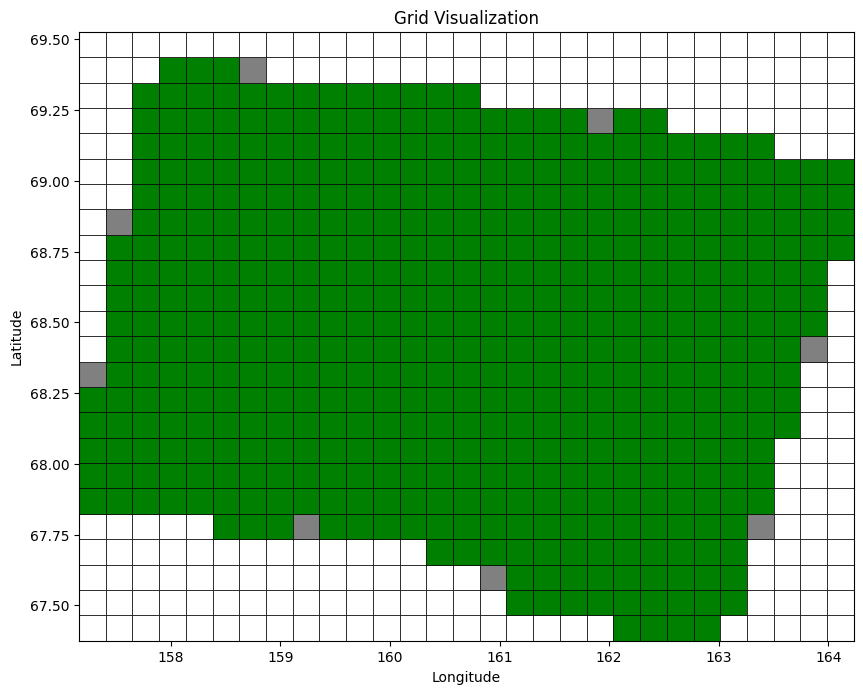

Using dynamic range: min_val=-0.0200, max_val=0.0200
Grid (162.04, 162.28, 67.38, 67.46): min=-0.0200, max=0.0200, points=12622
Grid (162.28, 162.53, 67.38, 67.46): min=-0.0200, max=0.0200, points=97104
Grid (162.53, 162.77, 67.38, 67.46): min=-0.0200, max=0.0200, points=172955
Grid (162.77, 163.01, 67.38, 67.46): min=-0.0200, max=0.0200, points=119712
Grid (161.06, 161.31, 67.46, 67.55): min=-0.0200, max=0.0200, points=11682
Grid (161.31, 161.55, 67.46, 67.55): min=-0.0200, max=0.0200, points=83096
Grid (161.55, 161.79, 67.46, 67.55): min=-0.0200, max=0.0200, points=169555
Grid (161.79, 162.04, 67.46, 67.55): min=-0.0200, max=0.0200, points=275746
Grid (162.04, 162.28, 67.46, 67.55): min=-0.0200, max=0.0200, points=348890
Grid (162.28, 162.53, 67.46, 67.55): min=-0.0200, max=0.0200, points=349172
Grid (162.53, 162.77, 67.46, 67.55): min=-0.0200, max=0.0200, points=274746
Grid (162.77, 163.01, 67.46, 67.55): min=-0.0200, max=0.0200, points=255235
Grid (163.01, 163.26, 67.46, 67.55): mi

In [3]:
subsidence_1920, lons, lats, zip_masked_1920 = prepare_subsidence_data('csk', '201920', 'orgsub', min_value=-0.02, max_value=0.02)
csk_grid = create_km_grid(lons, lats, resolution_km=10)
create_cdo_grid_description(csk_grid, output_file='csk_10km_grid.txt')



# Count the number of points in each grid cell
data_counts_1920 = []
for cell in csk_grid:
    lon_start, lon_end, lat_start, lat_end = cell
    mask = (zip_masked_1920[:, 0] >= lon_start) & (zip_masked_1920[:, 0] < lon_end) & (zip_masked_1920[:, 1] >= lat_start) & (zip_masked_1920[:, 1] < lat_end)
    data_counts_1920.append(np.sum(mask))

# Visualise the grid results
visualise_grid_results(csk_grid, data_counts_1920)


hist_csk_1920,_,_ = bin_valid_data(csk_grid, zip_masked_1920, bins=50, min_val=None, max_val=None,threshold=6000)



Valid histograms: 486


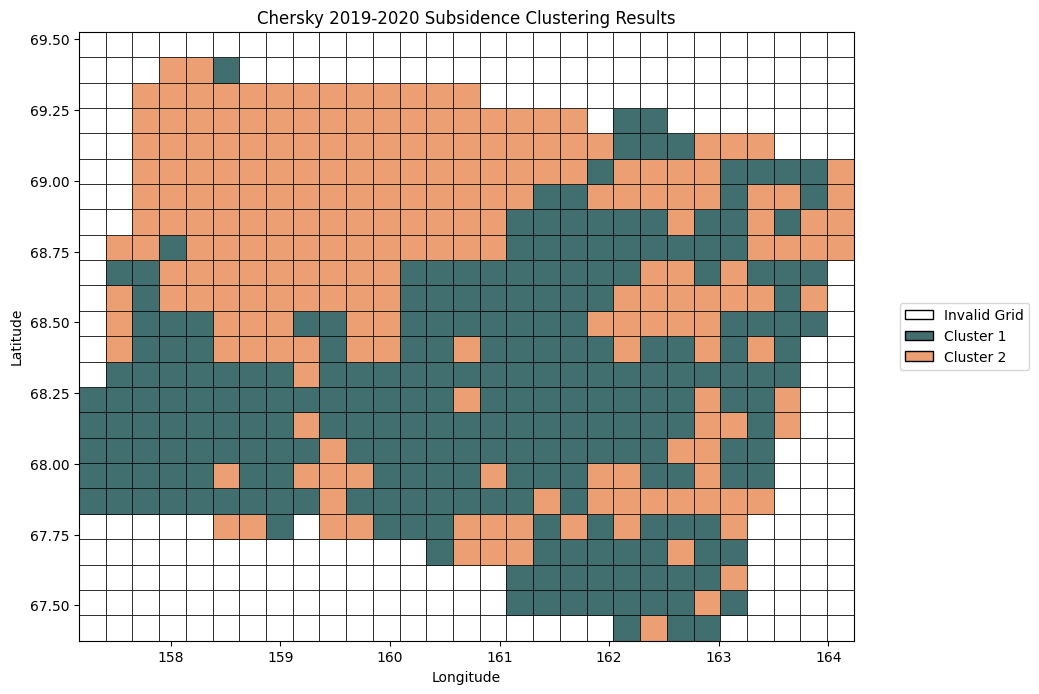

In [4]:

# Ensure valid grids are filtered correctly
data_counts_1920 = np.array(data_counts_1920)
valid_grids_mask = (data_counts_1920 >= 6000)
valid_histograms_1920 = hist_csk_1920[valid_grids_mask]

csk_grids_mask = valid_grids_mask.reshape(24, 29)  

# Save the mask for later use
np.save('csk_grids_mask.npy', csk_grids_mask)

if valid_histograms_1920.size == 0:
    print("No valid histograms found. Ensure input data has sufficient values.")
else:
    print(f"Valid histograms: {valid_histograms_1920.shape[0]}")

    # Step 2: EP-MEANS Clustering
    k_clusters = 2
    ep_means = EPMEANS(n_clusters=k_clusters)
    valid_histograms_1920 = valid_histograms_1920[~np.isnan(valid_histograms_1920).any(axis=1)]
    ep_means.fit(valid_histograms_1920)

    # Map cluster assignments back to the original grid
    cluster_assignments = np.full(len(csk_grid), -1)  # Initialize all grids as "No Data" (-1)
    cluster_assignments[valid_grids_mask] = ep_means.assignments  # Assign clusters only to valid grids

    
    # Define special values for each cluster
    cluster_values = {0: 111, 1: 222, 2: 333}
    updated_data_counts = np.array(data_counts_1920)  # Start with original data counts

    # Update the data_counts array with cluster values for valid grids
    for grid_index, cluster in enumerate(cluster_assignments):
        if cluster in cluster_values:  # Only valid clusters get updated
            updated_data_counts[grid_index] = cluster_values[cluster]

    # Visualize the updated grid
    visualise_updated_grid(csk_grids_mask, csk_grid, updated_data_counts, title="Chersky 2019-2020 Subsidence Clustering Results")
    

In [8]:


# Grid shape (as already defined)
nrows, ncols = csk_grids_mask.shape  # e.g., 27, 20

# Reshape flat cluster assignment array into 2D raster
cluster_raster = np.full(nrows * ncols, np.nan)
cluster_raster[valid_grids_mask] = ep_means.assignments
cluster_raster = cluster_raster.reshape(nrows, ncols)

# Assign meaningful values (optional but helpful for visualization)
cluster_raster_int = np.full_like(cluster_raster, fill_value=-1, dtype=int)
cluster_raster_int[cluster_raster == 0] = 111
cluster_raster_int[cluster_raster == 1] = 222
# If you had 3 clusters:
# cluster_raster_int[cluster_raster == 2] = 333

# Generate lat/lon centers from your grid
lat_centers = np.array([(cell[2] + cell[3]) / 2 for cell in csk_grid]).reshape(nrows, ncols)[:, 0]
lon_centers = np.array([(cell[0] + cell[1]) / 2 for cell in csk_grid]).reshape(nrows, ncols)[0, :]

# Write NetCDF
output_file = "Chersky_2019_2020_clusters.nc"
with nc.Dataset(output_file, 'w', format='NETCDF4') as ds:
    # Dimensions
    ds.createDimension('lat', nrows)
    ds.createDimension('lon', ncols)

    # Variables
    lat_var = ds.createVariable('lat', 'f4', ('lat',))
    lon_var = ds.createVariable('lon', 'f4', ('lon',))
    cluster_var = ds.createVariable('cluster_id', 'i4', ('lat', 'lon'), fill_value=-1)

    # Assign values
    lat_var[:] = lat_centers
    lon_var[:] = lon_centers
    cluster_var[:, :] = cluster_raster_int

    # Add metadata (optional)
    cluster_var.units = "categorical"
    cluster_var.description = "Cluster assignment: 111 = Cluster 1, 222 = Cluster 2, -1 = No Data"
    ds.title = "Chersky 2019–2020 Cluster Assignment Raster"
    ds.source = "EP-MEANS clustering on subsidence histograms"

print(f"✅ Cluster NetCDF file saved as: {output_file}")


✅ Cluster NetCDF file saved as: Chersky_2019_2020_clusters.nc
